# FUNCTIONS

In [12]:
from data_gen import generate_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
def extract_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Extract useful information from a given CloudFront DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame to extract information from. It should have columns 'date', 'time',
        'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.

    Returns:
        pd.DataFrame: A new DataFrame containing only the useful information extracted from the input DataFrame. The
        new DataFrame has columns 'datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', and 'cs_uri_stem'.
    """
    # merge date and time columns
    dataframe['datetime'] = pd.to_datetime(dataframe['date'] + ' ' + dataframe['time'])

    # drop the original date and time columns
    temp_df = dataframe.drop(['date', 'time'], axis=1, errors='ignore')

    # set datetime column as first column
    temp_df.insert(0, 'datetime', temp_df.pop('datetime'))

    # Extract useful information from df
    df = dataframe.loc[:, ['datetime', 'x_edge_location', 'c_ip', 'cs_method', 'sc_status', 'cs_uri_stem']]

    return df

In [14]:
def find_unique_addresses(dataframe: pd.DataFrame) -> np.ndarray:
    """
    Returns an array of unique IP addresses from the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the CloudFront access log data.

    Returns:
    np.ndarray: An array of unique IP addresses found in the 'c_ip' column of the DataFrame.
    """
    unique_ips = dataframe['c_ip'].unique()
    return unique_ips

def count_visits_per_ip(dataframe: pd.DataFrame, ip_address: str = None) -> pd.core.series.Series:
    """ 
    Returns the number of visits per IP address in the given DataFrame.
    If an IP address is specified, returns the number of visits for that IP only.
    """
    if ip_address:
        unique_ips = find_unique_addresses(dataframe)
        if ip_address in unique_ips:
            return dataframe['c_ip'].value_counts()[ip_address]
        else:
            return 0
    else:
        ip_counts = dataframe['c_ip'].value_counts()
        return ip_counts


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def show_edge_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Displays a pie chart of the traffic distribution between the top N edge locations in the given DataFrame.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the CloudFront access log data.
    top_n : int, optional
        The number of top edge locations to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    if top_n > 20:
        top_n = 20
        
    if 'x_edge_location' not in dataframe.columns:
        raise ValueError("Input dataframe does not have 'x_edge_location' column.")
    edge_location_counts = dataframe['x_edge_location'].value_counts()
    
    # Check if there are any edge location data
    if len(edge_location_counts) == 0:
        print('No edge location data found')
        return
    
    # Check if there are enough edge locations to display
    if len(edge_location_counts) < top_n:
        top_n = len(edge_location_counts)
    
    # Create a pie chart of the location counts
    plt.pie(edge_location_counts.head(top_n), labels=edge_location_counts.head(top_n).index, autopct='%1.1f%%')
    plt.title('Traffic between top {} edge locations'.format(top_n))
    plt.axis('equal')
    plt.show()

In [38]:
import json
import urllib.request

def get_location(ip: str) -> str:
  """
  Retrieve the country associated with an IP address.

    Parameters:
    ip (str): The IP address to lookup.

    Returns:
    str: The country associated with the IP address, or 'Unknown' if no country information is available.
  """
  response = urllib.request.urlopen('http://ipwho.is/'+ip)
  ipwhois = json.load(response)

  if 'country' in ipwhois:
    return ipwhois['country']
  else:
    return 'Unknown'


def plot_country_traffic(dataframe: pd.DataFrame, top_n: int = 10):
    """
    Plots a pie chart showing the distribution of traffic by country based on the given DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        A pandas DataFrame containing CloudFront access log data.
    top_n : int, optional
        The number of top countries to display in the pie chart. Defaults to 10 and is limited to a maximum of 20.
    """
    if top_n > 20:
        top_n = 20

    if 'c_ip' not in dataframe.columns:
        raise ValueError("Input dataframe does not have 'c_ip' column.")
    
    # Find location for each c_ip in the DataFrame
    dataframe['location'] = dataframe['c_ip'].apply(get_location)
    location_counts = dataframe['location'].value_counts().head(top_n)
    
       # Check if there are any country data
    if len(location_counts) == 0:
        print('No country data found')
        return
    
    # Check if there are enough countries to display
    if len(location_counts) < top_n:
        top_n = len(location_counts)
        

    # Create a pie chart of the location counts
    plt.pie(location_counts.values, labels=location_counts.index, autopct='%1.1f%%')
    plt.title('Traffic between top {} countries'.format(top_n))
    plt.axis('equal')
    plt.show()

In [43]:
def get_freq_endpoints(dataframe: pd.DataFrame, frequency=100) -> pd.DataFrame:
    """
    Returns a DataFrame containing the endpoints that were visited more than a specified frequency,
    grouped by the HTTP status code, method, and endpoint.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame containing the web access log data.
    frequency : int, optional
        The minimum number of times an endpoint must be visited to be included in the resulting DataFrame.
        Defaults to 100.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the endpoints that were visited more than the specified frequency,
        grouped by the HTTP status code, method, and endpoint.
        The DataFrame has the following columns: 'sc_status', 'cs_method', 'cs_uri_stem', and 'count'.
    """
    # handle empty input dataframe
    if dataframe.empty:
        return pd.DataFrame(columns=['sc_status', 'cs_method', 'cs_uri_stem', 'count'])

    # handle input dataframe that doesn't have the expected columns
    expected_columns = ['sc_status', 'cs_method', 'cs_uri_stem']
    if not all(col in dataframe.columns for col in expected_columns):
        raise ValueError(f"Input dataframe does not have the expected columns: {', '.join(expected_columns)}")

    # group the data by sc_status, cs_method, and endpoint, and count the occurrences
    count_df = dataframe.groupby(['sc_status', 'cs_method', 'cs_uri_stem']).size().reset_index(name='count')

    # filter the dataframe to only include rows with count >= freq
    result_df = count_df[count_df['count'] >= frequency]

    # return the resulting dataframe
    return result_df

In [18]:
def check_brute_force(dataframe: pd.DataFrame, threshold: int = 100) -> list:
    """Checks for potential brute force attacks in a DataFrame of CloudFront logs.
    
    Parameters:
    daframe (pd.DataFrame): A pandas DataFrame containing the data to be analyzed.
    threshold (int): An integer representing the maximum number of requests allowed within a 5-minute sliding window. Defaults to 100.
    """

    # Group the dataframe by endpoints and datetime
    grouped = dataframe.groupby(['cs_uri_stem', 'datetime'])

    # Create a sliding window of 5 minutes
    window_size = pd.Timedelta(minutes=5)
    windows = [grouped.filter(lambda x: ((x['datetime'] >= window_start) & (x['datetime'] < window_end)).any()).reset_index(drop=True)
               for window_start, window_end in zip(dataframe['datetime'], dataframe['datetime'] + window_size) 
               if not grouped.filter(lambda x: ((x['datetime'] >= window_start) & (x['datetime'] < window_end)).any()).empty]

    # Calculate the maximum count of requests for each window
    max_counts = [window.groupby('cs_uri_stem')['datetime'].count().max() for window in windows]

    # Flag any window with a maximum count exceeding threshold requests
    potential_attacks = [(window.iloc[0]['datetime'], window.iloc[-1]['datetime'])
                         for window, max_count in zip(windows, max_counts) if max_count > threshold]

    return potential_attacks

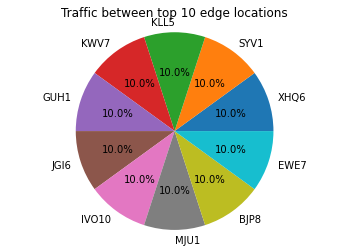

[]

In [50]:
# 1. Load the data 
full_df = generate_data()
df = extract_data(full_df)

# 2. Find unique IP addresses
find_unique_addresses(df)

# 3. Find how many times a specific IP address visited the website
count_visits_per_ip(df)

# 4.Show the distribution of traffic between edge locations
show_edge_traffic(df)

# 5.Show the distribution of traffic dependent on countries.
plot_country_traffic(df)

# 6. Find endpoints which were visited more than 100 times (default), depending on the HTTP code and method
get_freq_endpoints(df)

# 7.Check if there is a possible brute force attack
check_brute_force(df)